# Imports

In [294]:
# These are standard python modules
import json, time, urllib.parse
import matplotlib.pyplot as plt
import pandas as pd
# remove warnings while creating a dataframe
import warnings
warnings.filterwarnings('ignore')

# The 'requests' module is not a standard Python module. You will need to install this with pip/pip3 if you do not already have it
import requests

# Data Acquistion

The section below details the steps for data acquistion.
We have:
1. An excel sheet defining the subset of the English Wikipedia that represents a large number of articles about academy award winning movies. This sheet can be downloaded at: https://docs.google.com/spreadsheets/d/1A1h_7KAo7KXaVxdScJmIVPTvjb3IuY9oZhNV4ZHxrxw/edit?usp=sharing
2. The Pageviews API which provides access to desktop, mobile web, and mobile app traffic data from July 2015 through the previous complete month. The documentation for this API can be found at: https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews and the endpoint can be found at: https://wikimedia.org/api/rest_v1/#!/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end

The data from the excel sheet is stored into a pandas dataframe for ease of access and the request template for the API is defined below


In [126]:
excel_data_df = pd.read_excel('thank_the_academy.AUG.2023.csv.xlsx')
excel_data_df.head()

,name,url
0,Everything Everywhere All at Once,https://en.wikipedia.org/wiki/Everything_Every...
1,All Quiet on the Western Front (2022 film),https://en.wikipedia.org/wiki/All_Quiet_on_the...
2,The Whale (2022 film),https://en.wikipedia.org/wiki/The_Whale_(2022_...
3,Top Gun: Maverick,https://en.wikipedia.org/wiki/Top_Gun:_Maverick
4,Black Panther: Wakanda Forever,https://en.wikipedia.org/wiki/Black_Panther:_W...


The articles names are sorted to create an easy flow for the required output files in the latter part of this document

In [127]:
article_names = excel_data_df['name'].to_list()
article_names.sort()

**Note:** This code is a snippet from [notebook](https://drive.google.com/file/d/1XjFhd3eXx704tcdfQ4Q1OQn0LWKCRNJm/view?usp=sharing) and this sample code is licensed [CC-BY](https://creativecommons.org/licenses/by/4.0/)

In [128]:
#########
#
#    CONSTANTS
#

# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include your email address which will allow them
# to contact you if something happens - such as - your code exceeding rate limits - or some other error 
REQUEST_HEADERS = {
    'User-Agent': 'mshash@uw.edu, University of Washington, MSDS DATA 512 - AUTUMN 2023',
}

# This is just a list of English Wikipedia article titles that we can use for example requests
ARTICLE_TITLES = article_names

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_DESKTOP_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "desktop",      
    "agent":       "user",
    "article":     "",             
    "granularity": "monthly",
    "start":       "2015070100",   
    "end":         "2023093000"    
}

ARTICLE_PAGEVIEWS_MOBILE_APP_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "mobile-app",      
    "agent":       "user",
    "article":     "",             
    "granularity": "monthly",
    "start":       "2015070100",   
    "end":         "2023093000"    
}

ARTICLE_PAGEVIEWS_MOBILE_WEB_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "mobile-web",      
    "agent":       "user",
    "article":     "",             
    "granularity": "monthly",
    "start":       "2015070100",   
    "end":         "2023093000"    
}

In [129]:
#########
#
#    PROCEDURES/FUNCTIONS
#

def request_pageviews_per_article(article_title = None, 
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):

    # article title can be as a parameter to the call or in the request_template
    if article_title:
        request_template['article'] = article_title

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")

    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ','_'), safe='')
    request_template['article'] = article_title_encoded
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response


## Monthly desktop access

This section outlines how the API is called with a specific template to obtain monthly desktop data. This API has field in the request which differentiates the "access" type which can take values: desktop, mobile_app and mobile_web.
The template is as follows and is defined above:
```
    ARTICLE_PAGEVIEWS_DESKTOP_PARAMS_TEMPLATE = {
        "project":     "en.wikipedia.org",
        "access":      "desktop",      
        "agent":       "user",
        "article":     "",             
        "granularity": "monthly",
        "start":       "2015070100",   
        "end":         "2023093000"    
    }
```
It can be noted that the 'access' field is defined as 'desktop' above.
The API is called using the ```request_pageviews_per_article``` function which takes several parameters, but the only ones that we want to define and not take its default values are: 'request_template' and 'article_title'

In [130]:
desktop_views = {'items':[]}
for article_name in ARTICLE_TITLES:
    print("Getting pageview data for: ",article_name)
    desktop_views['items'].extend(request_pageviews_per_article(request_template = ARTICLE_PAGEVIEWS_DESKTOP_PARAMS_TEMPLATE, article_title = article_name)['items'])

Getting pageview data for:  12 Years a Slave (film)
Getting pageview data for:  1917 (2019 film)
Getting pageview data for:  20 Feet from Stardom
Getting pageview data for:  20,000 Leagues Under the Sea (1954 film)
Getting pageview data for:  2001: A Space Odyssey (film)
Getting pageview data for:  49th Parallel (film)
Getting pageview data for:  7 Faces of Dr. Lao
Getting pageview data for:  7th Heaven (1927 film)
Getting pageview data for:  8 Mile (film)
Getting pageview data for:  8½
Getting pageview data for:  A Beautiful Mind (film)
Getting pageview data for:  A Boy and His Dog (1946 film)
Getting pageview data for:  A Chance to Live
Getting pageview data for:  A Christmas Carol (1971 film)
Getting pageview data for:  A Close Shave
Getting pageview data for:  A Damsel in Distress (1937 film)
Getting pageview data for:  A Double Life (1947 film)
Getting pageview data for:  A Fantastic Woman
Getting pageview data for:  A Farewell to Arms (1932 film)
Getting pageview data for:  A Fis

Getting pageview data for:  Blue Jasmine
Getting pageview data for:  Blue Sky (1994 film)
Getting pageview data for:  Board and Care
Getting pageview data for:  Bob's Birthday
Getting pageview data for:  Body and Soul (1947 film)
Getting pageview data for:  Bohemian Rhapsody (film)
Getting pageview data for:  Bombshell (2019 film)
Getting pageview data for:  Bonnie and Clyde (film)
Getting pageview data for:  Bored of Education
Getting pageview data for:  Born Free
Getting pageview data for:  Born Yesterday (1950 film)
Getting pageview data for:  Born into Brothels
Getting pageview data for:  Born on the Fourth of July (film)
Getting pageview data for:  Bound for Glory (1976 film)
Getting pageview data for:  Bowling for Columbine
Getting pageview data for:  Boyhood (2014 film)
Getting pageview data for:  Boys Don't Cry (1999 film)
Getting pageview data for:  Boys Town (film)
Getting pageview data for:  Boys and Girls (1983 film)
Getting pageview data for:  Bram Stoker's Dracula (1992 f

Getting pageview data for:  Eternal Sunshine of the Spotless Mind
Getting pageview data for:  Every Child (film)
Getting pageview data for:  Everything Everywhere All at Once
Getting pageview data for:  Evita (1996 film)
Getting pageview data for:  Ex Machina (film)
Getting pageview data for:  Exodus (1960 film)
Getting pageview data for:  Facing Your Danger
Getting pageview data for:  Fame (1980 film)
Getting pageview data for:  Fanny and Alexander
Getting pageview data for:  Fantasia (1940 film)
Getting pageview data for:  Fantastic Beasts and Where to Find Them (film)
Getting pageview data for:  Fantastic Voyage
Getting pageview data for:  Fargo (1996 film)
Getting pageview data for:  Father Goose (film)
Getting pageview data for:  Father and Daughter (film)
Getting pageview data for:  Feast (2014 film)
Getting pageview data for:  Fellini's Casanova
Getting pageview data for:  Fences (film)
Getting pageview data for:  Ferdinand the Bull (film)
Getting pageview data for:  Fiddler on 

Getting pageview data for:  Jaws (film)
Getting pageview data for:  Jerry Maguire
Getting pageview data for:  Jezebel (1938 film)
Getting pageview data for:  Joan of Arc (1948 film)
Getting pageview data for:  Johann Mouse
Getting pageview data for:  Johnny Belinda (1948 film)
Getting pageview data for:  Johnny Eager
Getting pageview data for:  Jojo Rabbit
Getting pageview data for:  Joker (2019 film)
Getting pageview data for:  Journey into Self (1968 film)
Getting pageview data for:  Journey of Hope (film)
Getting pageview data for:  Judas and the Black Messiah
Getting pageview data for:  Judgment at Nuremberg
Getting pageview data for:  Judy (film)
Getting pageview data for:  Julia (1977 film)
Getting pageview data for:  Julius Caesar (1953 film)
Getting pageview data for:  Juno (film)
Getting pageview data for:  Jurassic Park (film)
Getting pageview data for:  Just Another Missing Kid
Getting pageview data for:  Karl Hess: Toward Liberty
Getting pageview data for:  Kentucky (film)


Getting pageview data for:  Nicholas and Alexandra
Getting pageview data for:  Nights of Cabiria
Getting pageview data for:  Nine from Little Rock
Getting pageview data for:  No Country for Old Men (film)
Getting pageview data for:  No Man's Land (2001 film)
Getting pageview data for:  No Time to Die
Getting pageview data for:  Nomadland (film)
Getting pageview data for:  None but the Lonely Heart (film)
Getting pageview data for:  Norma Rae
Getting pageview data for:  Norman Rockwell's World... An American Dream
Getting pageview data for:  North West Mounted Police (film)
Getting pageview data for:  Now, Voyager
Getting pageview data for:  Nowhere in Africa
Getting pageview data for:  Number Our Days
Getting pageview data for:  O.J.: Made in America
Getting pageview data for:  Of Pups and Puzzles
Getting pageview data for:  Oklahoma! (1955 film)
Getting pageview data for:  Oliver! (film)
Getting pageview data for:  Omnibus (film)
Getting pageview data for:  On Golden Pond (1981 film)


Getting pageview data for:  Sons and Lovers (film)
Getting pageview data for:  Sons of Liberty (film)
Getting pageview data for:  Sophie's Choice (film)
Getting pageview data for:  Soul (2020 film)
Getting pageview data for:  Sound of Metal
Getting pageview data for:  South Pacific (1958 film)
Getting pageview data for:  Spartacus (film)
Getting pageview data for:  Spawn of the North
Getting pageview data for:  Speaking of Animals and Their Families
Getting pageview data for:  Special Delivery (1978 film)
Getting pageview data for:  Spectre (2015 film)
Getting pageview data for:  Speed (1994 film)
Getting pageview data for:  Speedy Gonzales (film)
Getting pageview data for:  Spellbound (1945 film)
Getting pageview data for:  Spider-Man 2
Getting pageview data for:  Spider-Man: Into the Spider-Verse
Getting pageview data for:  Spirited Away
Getting pageview data for:  Splendor in the Grass
Getting pageview data for:  Spotlight (film)
Getting pageview data for:  Stagecoach (1939 film)
Ge

Getting pageview data for:  The Father (2020 film)
Getting pageview data for:  The Favourite
Getting pageview data for:  The Fighter
Getting pageview data for:  The Fighting Lady
Getting pageview data for:  The Fisher King
Getting pageview data for:  The Flight of the Gossamer Condor
Getting pageview data for:  The Fly (1980 film)
Getting pageview data for:  The Fly (1986 film)
Getting pageview data for:  The Fog of War
Getting pageview data for:  The Fortune Cookie
Getting pageview data for:  The French Connection (film)
Getting pageview data for:  The Fugitive (1993 film)
Getting pageview data for:  The Full Monty
Getting pageview data for:  The Garden of Allah (1936 film)
Getting pageview data for:  The Garden of the Finzi-Continis (film)
Getting pageview data for:  The Gay Divorcee
Getting pageview data for:  The Ghost and the Darkness
Getting pageview data for:  The Girl with the Dragon Tattoo (2011 film)
Getting pageview data for:  The Glenn Miller Story
Getting pageview data for

Getting pageview data for:  The Rose Tattoo (film)
Getting pageview data for:  The Salesman (2016 film)
Getting pageview data for:  The Sand Castle (film)
Getting pageview data for:  The Sandpiper
Getting pageview data for:  The Scoundrel (1935 film)
Getting pageview data for:  The Sea Around Us (film)
Getting pageview data for:  The Sea Inside
Getting pageview data for:  The Search
Getting pageview data for:  The Secret Land
Getting pageview data for:  The Secret in Their Eyes
Getting pageview data for:  The Seventh Veil
Getting pageview data for:  The Shape of Water
Getting pageview data for:  The Shop on Main Street
Getting pageview data for:  The Shore (2011 film)
Getting pageview data for:  The Silence of the Lambs (film)
Getting pageview data for:  The Silent Child
Getting pageview data for:  The Silent World
Getting pageview data for:  The Sin of Madelon Claudet
Getting pageview data for:  The Snake Pit
Getting pageview data for:  The Social Network
Getting pageview data for:  T

Getting pageview data for:  White Wilderness (film)
Getting pageview data for:  Who Are the DeBolts? And Where Did They Get Nineteen Kids?
Getting pageview data for:  Who Framed Roger Rabbit
Getting pageview data for:  Who's Afraid of Virginia Woolf? (film)
Getting pageview data for:  Who's Who in Animal Land
Getting pageview data for:  Why Korea?
Getting pageview data for:  Why Man Creates
Getting pageview data for:  Wild Wings
Getting pageview data for:  Wilson (1944 film)
Getting pageview data for:  Wings (1927 film)
Getting pageview data for:  Wings Over Everest
Getting pageview data for:  Winnie the Pooh and the Blustery Day
Getting pageview data for:  With Byrd at the South Pole
Getting pageview data for:  With a Song in My Heart (film)
Getting pageview data for:  With the Marines at Tarawa
Getting pageview data for:  Witness (1985 film)
Getting pageview data for:  Witness to War: Dr. Charlie Clements
Getting pageview data for:  Woman of the Year
Getting pageview data for:  Women

### Write this into a json file

In [275]:
with open("academy_monthly_desktop_<start201507>-<end202309>.json", "w") as final_desktop_data:
   json.dump(desktop_views, final_desktop_data) 

In [115]:
desktop_views_copy = desktop_views
mobile_combined_views_copy = mobile_combined_views

## Monthly mobile app access

This section outlines how the API is called with a specific template to obtain monthly mobile app data. This API has field in the request which differentiates the "access" type which can take values: desktop, mobile_app and mobile_web.
The template is as follows and is defined above:
```
    ARTICLE_PAGEVIEWS_DESKTOP_PARAMS_TEMPLATE = {
        "project":     "en.wikipedia.org",
        "access":      "mobile_app",      
        "agent":       "user",
        "article":     "",             
        "granularity": "monthly",
        "start":       "2015070100",   
        "end":         "2023093000"    
    }
```
It can be noted that the 'access' field is defined as 'mobile_app' above.
The API is called using the ```request_pageviews_per_article``` function which takes several parameters, but the only ones that we want to define and not take its default values are: 'request_template' and 'article_title'

In [131]:
mobile_app_views = {'items':[]}
for article_name in ARTICLE_TITLES:
    print("Getting pageview data for: ",article_name)
    mobile_app_views['items'].extend(request_pageviews_per_article(request_template = ARTICLE_PAGEVIEWS_MOBILE_APP_PARAMS_TEMPLATE, article_title = article_name)['items'])

Getting pageview data for:  12 Years a Slave (film)
Getting pageview data for:  1917 (2019 film)
Getting pageview data for:  20 Feet from Stardom
Getting pageview data for:  20,000 Leagues Under the Sea (1954 film)
Getting pageview data for:  2001: A Space Odyssey (film)
Getting pageview data for:  49th Parallel (film)
Getting pageview data for:  7 Faces of Dr. Lao
Getting pageview data for:  7th Heaven (1927 film)
Getting pageview data for:  8 Mile (film)
Getting pageview data for:  8½
Getting pageview data for:  A Beautiful Mind (film)
Getting pageview data for:  A Boy and His Dog (1946 film)
Getting pageview data for:  A Chance to Live
Getting pageview data for:  A Christmas Carol (1971 film)
Getting pageview data for:  A Close Shave
Getting pageview data for:  A Damsel in Distress (1937 film)
Getting pageview data for:  A Double Life (1947 film)
Getting pageview data for:  A Fantastic Woman
Getting pageview data for:  A Farewell to Arms (1932 film)
Getting pageview data for:  A Fis

Getting pageview data for:  Blue Jasmine
Getting pageview data for:  Blue Sky (1994 film)
Getting pageview data for:  Board and Care
Getting pageview data for:  Bob's Birthday
Getting pageview data for:  Body and Soul (1947 film)
Getting pageview data for:  Bohemian Rhapsody (film)
Getting pageview data for:  Bombshell (2019 film)
Getting pageview data for:  Bonnie and Clyde (film)
Getting pageview data for:  Bored of Education
Getting pageview data for:  Born Free
Getting pageview data for:  Born Yesterday (1950 film)
Getting pageview data for:  Born into Brothels
Getting pageview data for:  Born on the Fourth of July (film)
Getting pageview data for:  Bound for Glory (1976 film)
Getting pageview data for:  Bowling for Columbine
Getting pageview data for:  Boyhood (2014 film)
Getting pageview data for:  Boys Don't Cry (1999 film)
Getting pageview data for:  Boys Town (film)
Getting pageview data for:  Boys and Girls (1983 film)
Getting pageview data for:  Bram Stoker's Dracula (1992 f

Getting pageview data for:  Eternal Sunshine of the Spotless Mind
Getting pageview data for:  Every Child (film)
Getting pageview data for:  Everything Everywhere All at Once
Getting pageview data for:  Evita (1996 film)
Getting pageview data for:  Ex Machina (film)
Getting pageview data for:  Exodus (1960 film)
Getting pageview data for:  Facing Your Danger
Getting pageview data for:  Fame (1980 film)
Getting pageview data for:  Fanny and Alexander
Getting pageview data for:  Fantasia (1940 film)
Getting pageview data for:  Fantastic Beasts and Where to Find Them (film)
Getting pageview data for:  Fantastic Voyage
Getting pageview data for:  Fargo (1996 film)
Getting pageview data for:  Father Goose (film)
Getting pageview data for:  Father and Daughter (film)
Getting pageview data for:  Feast (2014 film)
Getting pageview data for:  Fellini's Casanova
Getting pageview data for:  Fences (film)
Getting pageview data for:  Ferdinand the Bull (film)
Getting pageview data for:  Fiddler on 

Getting pageview data for:  Jaws (film)
Getting pageview data for:  Jerry Maguire
Getting pageview data for:  Jezebel (1938 film)
Getting pageview data for:  Joan of Arc (1948 film)
Getting pageview data for:  Johann Mouse
Getting pageview data for:  Johnny Belinda (1948 film)
Getting pageview data for:  Johnny Eager
Getting pageview data for:  Jojo Rabbit
Getting pageview data for:  Joker (2019 film)
Getting pageview data for:  Journey into Self (1968 film)
Getting pageview data for:  Journey of Hope (film)
Getting pageview data for:  Judas and the Black Messiah
Getting pageview data for:  Judgment at Nuremberg
Getting pageview data for:  Judy (film)
Getting pageview data for:  Julia (1977 film)
Getting pageview data for:  Julius Caesar (1953 film)
Getting pageview data for:  Juno (film)
Getting pageview data for:  Jurassic Park (film)
Getting pageview data for:  Just Another Missing Kid
Getting pageview data for:  Karl Hess: Toward Liberty
Getting pageview data for:  Kentucky (film)


Getting pageview data for:  Nicholas and Alexandra
Getting pageview data for:  Nights of Cabiria
Getting pageview data for:  Nine from Little Rock
Getting pageview data for:  No Country for Old Men (film)
Getting pageview data for:  No Man's Land (2001 film)
Getting pageview data for:  No Time to Die
Getting pageview data for:  Nomadland (film)
Getting pageview data for:  None but the Lonely Heart (film)
Getting pageview data for:  Norma Rae
Getting pageview data for:  Norman Rockwell's World... An American Dream
Getting pageview data for:  North West Mounted Police (film)
Getting pageview data for:  Now, Voyager
Getting pageview data for:  Nowhere in Africa
Getting pageview data for:  Number Our Days
Getting pageview data for:  O.J.: Made in America
Getting pageview data for:  Of Pups and Puzzles
Getting pageview data for:  Oklahoma! (1955 film)
Getting pageview data for:  Oliver! (film)
Getting pageview data for:  Omnibus (film)
Getting pageview data for:  On Golden Pond (1981 film)


Getting pageview data for:  Sons and Lovers (film)
Getting pageview data for:  Sons of Liberty (film)
Getting pageview data for:  Sophie's Choice (film)
Getting pageview data for:  Soul (2020 film)
Getting pageview data for:  Sound of Metal
Getting pageview data for:  South Pacific (1958 film)
Getting pageview data for:  Spartacus (film)
Getting pageview data for:  Spawn of the North
Getting pageview data for:  Speaking of Animals and Their Families
Getting pageview data for:  Special Delivery (1978 film)
Getting pageview data for:  Spectre (2015 film)
Getting pageview data for:  Speed (1994 film)
Getting pageview data for:  Speedy Gonzales (film)
Getting pageview data for:  Spellbound (1945 film)
Getting pageview data for:  Spider-Man 2
Getting pageview data for:  Spider-Man: Into the Spider-Verse
Getting pageview data for:  Spirited Away
Getting pageview data for:  Splendor in the Grass
Getting pageview data for:  Spotlight (film)
Getting pageview data for:  Stagecoach (1939 film)
Ge

Getting pageview data for:  The Father (2020 film)
Getting pageview data for:  The Favourite
Getting pageview data for:  The Fighter
Getting pageview data for:  The Fighting Lady
Getting pageview data for:  The Fisher King
Getting pageview data for:  The Flight of the Gossamer Condor
Getting pageview data for:  The Fly (1980 film)
Getting pageview data for:  The Fly (1986 film)
Getting pageview data for:  The Fog of War
Getting pageview data for:  The Fortune Cookie
Getting pageview data for:  The French Connection (film)
Getting pageview data for:  The Fugitive (1993 film)
Getting pageview data for:  The Full Monty
Getting pageview data for:  The Garden of Allah (1936 film)
Getting pageview data for:  The Garden of the Finzi-Continis (film)
Getting pageview data for:  The Gay Divorcee
Getting pageview data for:  The Ghost and the Darkness
Getting pageview data for:  The Girl with the Dragon Tattoo (2011 film)
Getting pageview data for:  The Glenn Miller Story
Getting pageview data for

Getting pageview data for:  The Rose Tattoo (film)
Getting pageview data for:  The Salesman (2016 film)
Getting pageview data for:  The Sand Castle (film)
Getting pageview data for:  The Sandpiper
Getting pageview data for:  The Scoundrel (1935 film)
Getting pageview data for:  The Sea Around Us (film)
Getting pageview data for:  The Sea Inside
Getting pageview data for:  The Search
Getting pageview data for:  The Secret Land
Getting pageview data for:  The Secret in Their Eyes
Getting pageview data for:  The Seventh Veil
Getting pageview data for:  The Shape of Water
Getting pageview data for:  The Shop on Main Street
Getting pageview data for:  The Shore (2011 film)
Getting pageview data for:  The Silence of the Lambs (film)
Getting pageview data for:  The Silent Child
Getting pageview data for:  The Silent World
Getting pageview data for:  The Sin of Madelon Claudet
Getting pageview data for:  The Snake Pit
Getting pageview data for:  The Social Network
Getting pageview data for:  T

Getting pageview data for:  White Wilderness (film)
Getting pageview data for:  Who Are the DeBolts? And Where Did They Get Nineteen Kids?
Getting pageview data for:  Who Framed Roger Rabbit
Getting pageview data for:  Who's Afraid of Virginia Woolf? (film)
Getting pageview data for:  Who's Who in Animal Land
Getting pageview data for:  Why Korea?
Getting pageview data for:  Why Man Creates
Getting pageview data for:  Wild Wings
Getting pageview data for:  Wilson (1944 film)
Getting pageview data for:  Wings (1927 film)
Getting pageview data for:  Wings Over Everest
Getting pageview data for:  Winnie the Pooh and the Blustery Day
Getting pageview data for:  With Byrd at the South Pole
Getting pageview data for:  With a Song in My Heart (film)
Getting pageview data for:  With the Marines at Tarawa
Getting pageview data for:  Witness (1985 film)
Getting pageview data for:  Witness to War: Dr. Charlie Clements
Getting pageview data for:  Woman of the Year
Getting pageview data for:  Women

## Monthly mobile web access

This section outlines how the API is called with a specific template to obtain monthly mobile web data. This API has field in the request which differentiates the "access" type which can take values: desktop, mobile_app and mobile_web.
The template is as follows and is defined above:
```
    ARTICLE_PAGEVIEWS_DESKTOP_PARAMS_TEMPLATE = {
        "project":     "en.wikipedia.org",
        "access":      "mobile_web",      
        "agent":       "user",
        "article":     "",             
        "granularity": "monthly",
        "start":       "2015070100",   
        "end":         "2023093000"    
    }
```
It can be noted that the 'access' field is defined as 'mobile_web' above.
The API is called using the ```request_pageviews_per_article``` function which takes several parameters, but the only ones that we want to define and not take its default values are: 'request_template' and 'article_title'

In [132]:
mobile_web_views = {'items':[]}
for article_name in ARTICLE_TITLES:
    print("Getting pageview data for: ",article_name)
    mobile_web_views['items'].extend(request_pageviews_per_article(request_template = ARTICLE_PAGEVIEWS_MOBILE_WEB_PARAMS_TEMPLATE, article_title = article_name)['items'])

Getting pageview data for:  12 Years a Slave (film)
Getting pageview data for:  1917 (2019 film)
Getting pageview data for:  20 Feet from Stardom
Getting pageview data for:  20,000 Leagues Under the Sea (1954 film)
Getting pageview data for:  2001: A Space Odyssey (film)
Getting pageview data for:  49th Parallel (film)
Getting pageview data for:  7 Faces of Dr. Lao
Getting pageview data for:  7th Heaven (1927 film)
Getting pageview data for:  8 Mile (film)
Getting pageview data for:  8½
Getting pageview data for:  A Beautiful Mind (film)
Getting pageview data for:  A Boy and His Dog (1946 film)
Getting pageview data for:  A Chance to Live
Getting pageview data for:  A Christmas Carol (1971 film)
Getting pageview data for:  A Close Shave
Getting pageview data for:  A Damsel in Distress (1937 film)
Getting pageview data for:  A Double Life (1947 film)
Getting pageview data for:  A Fantastic Woman
Getting pageview data for:  A Farewell to Arms (1932 film)
Getting pageview data for:  A Fis

Getting pageview data for:  Blue Jasmine
Getting pageview data for:  Blue Sky (1994 film)
Getting pageview data for:  Board and Care
Getting pageview data for:  Bob's Birthday
Getting pageview data for:  Body and Soul (1947 film)
Getting pageview data for:  Bohemian Rhapsody (film)
Getting pageview data for:  Bombshell (2019 film)
Getting pageview data for:  Bonnie and Clyde (film)
Getting pageview data for:  Bored of Education
Getting pageview data for:  Born Free
Getting pageview data for:  Born Yesterday (1950 film)
Getting pageview data for:  Born into Brothels
Getting pageview data for:  Born on the Fourth of July (film)
Getting pageview data for:  Bound for Glory (1976 film)
Getting pageview data for:  Bowling for Columbine
Getting pageview data for:  Boyhood (2014 film)
Getting pageview data for:  Boys Don't Cry (1999 film)
Getting pageview data for:  Boys Town (film)
Getting pageview data for:  Boys and Girls (1983 film)
Getting pageview data for:  Bram Stoker's Dracula (1992 f

Getting pageview data for:  Eternal Sunshine of the Spotless Mind
Getting pageview data for:  Every Child (film)
Getting pageview data for:  Everything Everywhere All at Once
Getting pageview data for:  Evita (1996 film)
Getting pageview data for:  Ex Machina (film)
Getting pageview data for:  Exodus (1960 film)
Getting pageview data for:  Facing Your Danger
Getting pageview data for:  Fame (1980 film)
Getting pageview data for:  Fanny and Alexander
Getting pageview data for:  Fantasia (1940 film)
Getting pageview data for:  Fantastic Beasts and Where to Find Them (film)
Getting pageview data for:  Fantastic Voyage
Getting pageview data for:  Fargo (1996 film)
Getting pageview data for:  Father Goose (film)
Getting pageview data for:  Father and Daughter (film)
Getting pageview data for:  Feast (2014 film)
Getting pageview data for:  Fellini's Casanova
Getting pageview data for:  Fences (film)
Getting pageview data for:  Ferdinand the Bull (film)
Getting pageview data for:  Fiddler on 

Getting pageview data for:  Jaws (film)
Getting pageview data for:  Jerry Maguire
Getting pageview data for:  Jezebel (1938 film)
Getting pageview data for:  Joan of Arc (1948 film)
Getting pageview data for:  Johann Mouse
Getting pageview data for:  Johnny Belinda (1948 film)
Getting pageview data for:  Johnny Eager
Getting pageview data for:  Jojo Rabbit
Getting pageview data for:  Joker (2019 film)
Getting pageview data for:  Journey into Self (1968 film)
Getting pageview data for:  Journey of Hope (film)
Getting pageview data for:  Judas and the Black Messiah
Getting pageview data for:  Judgment at Nuremberg
Getting pageview data for:  Judy (film)
Getting pageview data for:  Julia (1977 film)
Getting pageview data for:  Julius Caesar (1953 film)
Getting pageview data for:  Juno (film)
Getting pageview data for:  Jurassic Park (film)
Getting pageview data for:  Just Another Missing Kid
Getting pageview data for:  Karl Hess: Toward Liberty
Getting pageview data for:  Kentucky (film)


Getting pageview data for:  Nicholas and Alexandra
Getting pageview data for:  Nights of Cabiria
Getting pageview data for:  Nine from Little Rock
Getting pageview data for:  No Country for Old Men (film)
Getting pageview data for:  No Man's Land (2001 film)
Getting pageview data for:  No Time to Die
Getting pageview data for:  Nomadland (film)
Getting pageview data for:  None but the Lonely Heart (film)
Getting pageview data for:  Norma Rae
Getting pageview data for:  Norman Rockwell's World... An American Dream
Getting pageview data for:  North West Mounted Police (film)
Getting pageview data for:  Now, Voyager
Getting pageview data for:  Nowhere in Africa
Getting pageview data for:  Number Our Days
Getting pageview data for:  O.J.: Made in America
Getting pageview data for:  Of Pups and Puzzles
Getting pageview data for:  Oklahoma! (1955 film)
Getting pageview data for:  Oliver! (film)
Getting pageview data for:  Omnibus (film)
Getting pageview data for:  On Golden Pond (1981 film)


Getting pageview data for:  Sons and Lovers (film)
Getting pageview data for:  Sons of Liberty (film)
Getting pageview data for:  Sophie's Choice (film)
Getting pageview data for:  Soul (2020 film)
Getting pageview data for:  Sound of Metal
Getting pageview data for:  South Pacific (1958 film)
Getting pageview data for:  Spartacus (film)
Getting pageview data for:  Spawn of the North
Getting pageview data for:  Speaking of Animals and Their Families
Getting pageview data for:  Special Delivery (1978 film)
Getting pageview data for:  Spectre (2015 film)
Getting pageview data for:  Speed (1994 film)
Getting pageview data for:  Speedy Gonzales (film)
Getting pageview data for:  Spellbound (1945 film)
Getting pageview data for:  Spider-Man 2
Getting pageview data for:  Spider-Man: Into the Spider-Verse
Getting pageview data for:  Spirited Away
Getting pageview data for:  Splendor in the Grass
Getting pageview data for:  Spotlight (film)
Getting pageview data for:  Stagecoach (1939 film)
Ge

Getting pageview data for:  The Father (2020 film)
Getting pageview data for:  The Favourite
Getting pageview data for:  The Fighter
Getting pageview data for:  The Fighting Lady
Getting pageview data for:  The Fisher King
Getting pageview data for:  The Flight of the Gossamer Condor
Getting pageview data for:  The Fly (1980 film)
Getting pageview data for:  The Fly (1986 film)
Getting pageview data for:  The Fog of War
Getting pageview data for:  The Fortune Cookie
Getting pageview data for:  The French Connection (film)
Getting pageview data for:  The Fugitive (1993 film)
Getting pageview data for:  The Full Monty
Getting pageview data for:  The Garden of Allah (1936 film)
Getting pageview data for:  The Garden of the Finzi-Continis (film)
Getting pageview data for:  The Gay Divorcee
Getting pageview data for:  The Ghost and the Darkness
Getting pageview data for:  The Girl with the Dragon Tattoo (2011 film)
Getting pageview data for:  The Glenn Miller Story
Getting pageview data for

Getting pageview data for:  The Rose Tattoo (film)
Getting pageview data for:  The Salesman (2016 film)
Getting pageview data for:  The Sand Castle (film)
Getting pageview data for:  The Sandpiper
Getting pageview data for:  The Scoundrel (1935 film)
Getting pageview data for:  The Sea Around Us (film)
Getting pageview data for:  The Sea Inside
Getting pageview data for:  The Search
Getting pageview data for:  The Secret Land
Getting pageview data for:  The Secret in Their Eyes
Getting pageview data for:  The Seventh Veil
Getting pageview data for:  The Shape of Water
Getting pageview data for:  The Shop on Main Street
Getting pageview data for:  The Shore (2011 film)
Getting pageview data for:  The Silence of the Lambs (film)
Getting pageview data for:  The Silent Child
Getting pageview data for:  The Silent World
Getting pageview data for:  The Sin of Madelon Claudet
Getting pageview data for:  The Snake Pit
Getting pageview data for:  The Social Network
Getting pageview data for:  T

Getting pageview data for:  White Wilderness (film)
Getting pageview data for:  Who Are the DeBolts? And Where Did They Get Nineteen Kids?
Getting pageview data for:  Who Framed Roger Rabbit
Getting pageview data for:  Who's Afraid of Virginia Woolf? (film)
Getting pageview data for:  Who's Who in Animal Land
Getting pageview data for:  Why Korea?
Getting pageview data for:  Why Man Creates
Getting pageview data for:  Wild Wings
Getting pageview data for:  Wilson (1944 film)
Getting pageview data for:  Wings (1927 film)
Getting pageview data for:  Wings Over Everest
Getting pageview data for:  Winnie the Pooh and the Blustery Day
Getting pageview data for:  With Byrd at the South Pole
Getting pageview data for:  With a Song in My Heart (film)
Getting pageview data for:  With the Marines at Tarawa
Getting pageview data for:  Witness (1985 film)
Getting pageview data for:  Witness to War: Dr. Charlie Clements
Getting pageview data for:  Woman of the Year
Getting pageview data for:  Women

## Consolidating mobile app views and browser/web views

Above, there were two API calls to obtain mobile view data - mobile app and mobile web. However, for analytics purposes it is easier to consolidate or combine these two responses to form a combined mobile views json object.

In order to combine information from the two API calls, the 'views' field in both are summed up to make one count for all mobile pageviews. Since the article field has been ordered from before it is true that these two json_objects store article_name and 'timestamp' in the same order. A quick check can also be performed to ensure that this is really true

In [236]:
a = {}
b = {}
for item1 in mobile_app_views['items']:
    article_name = item1['article']
    if article_name in a:
        a[article_name].append(item1['timestamp'])
    else:
        a[article_name] = [item1['timestamp']]
for item2 in mobile_web_views['items']:
    article_name = item2['article']
    if article_name in b:
        b[article_name].append(item2['timestamp'])
    else:
        b[article_name] = [item2['timestamp']]
        
print(a==b)

True


The code above ensures that the two json objects: ```mobile_app_views``` and ```mobile_web_views``` are stored in the same order with respect to (article, timestamp). This makes the consolidation or combining steps much easier.

In [134]:
mobile_combined_views_list = []
for item1, item2 in zip(mobile_app_views['items'], mobile_web_views['items']):
    combined_item = {
        'project': item1['project'],
        'article': item1['article'],
        'granularity': item1['granularity'],
        'timestamp': item1['timestamp'],
        'agent': item1['agent'],
        'views': item1['views'] + item2['views']  
    }
    mobile_combined_views_list.append(combined_item)
mobile_combined_views = {
    'items': mobile_combined_views_list
}

### Write this into a json file

In [278]:
with open("academy_monthly_mobile_<start201507>-<end2023-9>.json", "w") as final_mobile_data:
   json.dump(mobile_combined_views, final_mobile_data) 

## Creating monthly cumulative views 

This section details how the views from all types of devices - desktop and mobile (both app and web) are combined to create a cumulative view json object. Leveraging the same ordering of the two json objects, a similar approach to the one written above can be used. 

However, again there must be a check to ensure that this ordering is indeed the same between the two json objects

In [237]:
a = {}
b = {}
for item1 in mobile_combined_views['items']:
    article_name = item1['article']
    if article_name in a:
        a[article_name].append(item1['timestamp'])
    else:
        a[article_name] = [item1['timestamp']]
for item2 in desktop_views['items']:
    article_name = item2['article']
    if article_name in b:
        b[article_name].append(item2['timestamp'])
    else:
        b[article_name] = [item2['timestamp']]
        
print(a==b)

True


The code above ensures that the two json objects: ```mobile_combined_views``` and ```desktop_views``` are stored in the same order with respect to (article, timestamp). This makes the consolidation or combining steps much easier.

In [138]:
all_combined_views_list = []
for item1, item2 in zip(mobile_combined_views['items'], desktop_views['items']):
    combined_item = {
        'project': item1['project'],
        'article': item1['article'],
        'granularity': item1['granularity'],
        'timestamp': item1['timestamp'],
        'agent': item1['agent'],
        'views': item1['views'] + item2['views']  
    }
    all_combined_views_list.append(combined_item)
all_combined_views = {
    'items': all_combined_views_list
}

### Write this into a json file

In [280]:
with open("academy_monthly_cumulative_<start201507>-<end202309>.json", "w") as final_combined_data:
   json.dump(all_combined_views, final_combined_data) 

# Analysis

This section is dedicated to basic visual analysis of all the data obtained above. This section will result in 3 different graphs analysing different metrics within the same data. 

## Graph 1: Maximum Average and Minimum Average
**Description:** The first graph should contain time series for the articles that have the highest average monthly page requests and the lowest average monthly page requests for desktop access and mobile access. Your graph should have four lines (max desktop, min desktop, max mobile, min mobile).

**Process:** The code below describes the steps involved in creating this visualization. The first step involves transforming the data to create a more suitable representation for this use case. Since the points of analyses involve highest and lowest average monthly page requests, the cells below try to create a dictionary that is of the following structure:
```
res = {
    'article_name' : {
        'sum_monthly_views': some_number,
        'no_of_months': some_number,
        'avg_monthly_views': some_number
    }
}
```
This structure helps to store the information required for this analyses and can be further sorted to identify the min and max values for each device type.

In [160]:
res_mobile_views = {}
for item in mobile_combined_views['items']:
    article_name = item['article']
    if article_name in res_mobile_views:
        res_mobile_views[article_name]['sum_monthly_view'] += item['views']
        res_mobile_views[article_name]['no_of_months'] += 1
    else:
        res_mobile_views[article_name] = {}
        res_mobile_views[article_name]['sum_monthly_view'] = item['views']
        res_mobile_views[article_name]['no_of_months'] = 1
        res_mobile_views[article_name]['access'] = 'mobile'

In [161]:
res_desktop_views = {}
for item in desktop_views['items']:
    article_name = item['article']
    if article_name in res_desktop_views:
        res_desktop_views[article_name]['sum_monthly_view'] += item['views']
        res_desktop_views[article_name]['no_of_months'] += 1
    else:
        res_desktop_views[article_name] = {}
        res_desktop_views[article_name]['sum_monthly_view'] = item['views']
        res_desktop_views[article_name]['no_of_months'] = 1
        res_desktop_views[article_name]['access'] = 'desktop'

### Add average views

In [164]:
for article in res_mobile_views:
    res_mobile_views[article]['avg_monthly_views'] = round(res_mobile_views[article]['sum_monthly_view']/res_mobile_views[article]['no_of_months'],2)

for article in res_desktop_views:
    res_desktop_views[article]['avg_monthly_views'] = round(res_desktop_views[article]['sum_monthly_view']/res_desktop_views[article]['no_of_months'],2)

### Sort the dictionaries using key as avg_monthly_views

In [165]:
res_mobile_views = sorted(res_mobile_views.items(), key = lambda x: x[1]['avg_monthly_views'], reverse=True)
res_desktop_views = sorted(res_desktop_views.items(), key = lambda x: x[1]['avg_monthly_views'], reverse=True)

### Once the dictionaries have been sorted, the max and min values can be extracted from the first and last elements of the json object.

In [168]:
max_avg_mobile = res_mobile_views[0]
max_avg_desktop = res_desktop_views[0]

min_avg_mobile = res_mobile_views[len(res_mobile_views)-1]
min_avg_desktop = res_desktop_views[len(res_desktop_views)-1]

In [169]:
print(max_avg_mobile)
print(max_avg_desktop)
print(min_avg_mobile)
print(min_avg_desktop)

('The_Whale_(2022_film)', {'sum_monthly_view': 7881193, 'no_of_months': 15, 'access': 'mobile', 'avg_monthly_views': 525412.87})
('Joker_(2019_film)', {'sum_monthly_view': 13661755, 'no_of_months': 63, 'access': 'desktop', 'avg_monthly_views': 216853.25})
('Project_Hope_(film)', {'sum_monthly_view': 902, 'no_of_months': 99, 'access': 'mobile', 'avg_monthly_views': 9.11})
('Project_Hope_(film)', {'sum_monthly_view': 3625, 'no_of_months': 99, 'access': 'desktop', 'avg_monthly_views': 36.62})


In [170]:
mobile_article_minmax = [min_avg_mobile[0], max_avg_mobile[0]]
desktop_article_minmax = [min_avg_desktop[0], max_avg_desktop[0]]

### Creating a dataframe that can be used for the visualization

Using the operations and intermediary data structures above, all the information is consolidates into a dataframe with meaningful column names that can be used while creating the visualizations.

graph1 is a dataframe with 4 columns:
1. article - the name of the article 
2. views - the monthly views for that article 
3. date - the timestamp field to define the month 
4. type - defines the type of device and if it is the article with min or max average monthly views. It can take 4 values: min_mobile_views, max_mobile_views, min_device_views and max_device_views



In [295]:
graph1 = pd.DataFrame(columns = ['article', 'views', 'date', 'type'])
for item in mobile_combined_views['items']:
    if item['article'] == mobile_article_minmax[0]:
        d = {'article': item['article'], 'views': item['views'], 'date': item['timestamp'], 'type': 'min_mobile_views'}
        graph1 = graph1.append(d,
        ignore_index = True)
    elif item['article'] == mobile_article_minmax[1]:
        d = {'article': item['article'], 'views': item['views'], 'date': item['timestamp'], 'type': 'max_mobile_views'}
        graph1 = graph1.append(d,
        ignore_index = True)
for item in desktop_views['items']:
    if item['article'] == desktop_article_minmax[0]:
        d = {'article': item['article'], 'views': item['views'], 'date': item['timestamp'], 'type': 'min_desktop_views'}
        graph1 = graph1.append(d,
        ignore_index = True)
    elif item['article'] == desktop_article_minmax[1]:
        d = {'article': item['article'], 'views': item['views'], 'date': item['timestamp'], 'type': 'max_desktop_views'}
        graph1 = graph1.append(d,
        ignore_index = True)

### The date value in this dataframe is taken from the original API response which is in the format %Y%m%d%H and it converted to the pandas default datetime format

In [195]:
graph1['date'] = pd.to_datetime(graph1['date'], format='%Y%m%d%H')

## Plotting the graph

The code below is used to plot the graph which contains time series for the articles that have the highest average monthly page requests and the lowest average monthly page requests for desktop access and mobile access. This graph  has four lines (max desktop, min desktop, max mobile, min mobile). 
* The legend for these lines can be found in the legend.
* The Y-axis represents the monthly pageviews for these articles and is log-scaled for improved readability. If the scale is not log-scaled, it is difficult to compare legends with highly varying ranges.
* The X-axis represents time, where each grid line is a year.


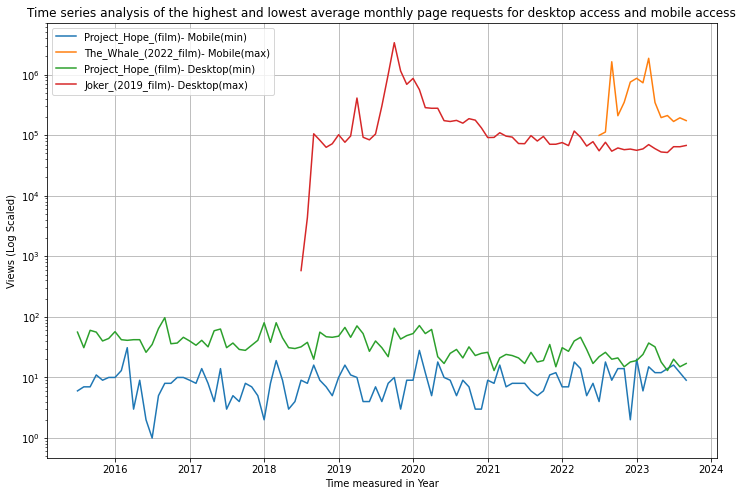

In [284]:
plt.figure(figsize=(12,8))
label1 = mobile_article_minmax[0]
label2 = mobile_article_minmax[1]
label3 = desktop_article_minmax[0]
label4 = desktop_article_minmax[1]

g1 = graph1[graph1['type'] == 'min_mobile_views']
g2 = graph1[graph1['type'] == 'max_mobile_views']
g3 = graph1[graph1['type'] == 'min_desktop_views']
g4 = graph1[graph1['type'] == 'max_desktop_views']


plt.semilogy(g1['date'], g1['views'], label=label1+'- Mobile(min)')
plt.semilogy(g2['date'], g2['views'], label=label2+'- Mobile(max)')
plt.semilogy(g3['date'], g3['views'], label=label3+'- Desktop(min)')
plt.semilogy(g4['date'], g4['views'], label=label4+'- Desktop(max)')

plt.xlabel('Time measured in Year')
plt.ylabel('Views (Log Scaled)')
plt.title('Time series analysis of the highest and lowest average monthly page requests for desktop access and mobile access')
plt.legend()
plt.grid(True)

plt.show()

## Graph 2: Top 10 Peak Page Views
**Description:** The second graph should contain time series for the top 10 article pages by largest (peak) page views over the entire time by access type. You first find the month for each article that contains the highest (peak) page views, and then order the articles by these peak values. Your graph should contain the top 10 for desktop and top 10 for mobile access (20 lines).

**Process:** The first step is detailed in the description, which is to find the month for each article that contains the highest (peak) page views. To store the results of this operation, I created a dictionary to store each article name and intially, a list of all its values across all the months. The ```peak_mobile``` and ```peak_device``` dictionaries are used to store this information. The format of the stored information is as follows:
```
peak_mobile = {
    'article_name1': [view_for_m1, view_for_m2, ...],
    'article_name2': [view_for_m1, view_for_m2, ...],
    'article_name3': [view_for_m1, view_for_m2, ...],
    ...
}
```

In [206]:
# Copies are made of the original views json objects to perform further operations
mobile = mobile_combined_views
desktop = desktop_views

In [217]:
peak_mobile = {}
for item in mobile['items']:
    article_name = item['article']
    if article_name in peak_mobile:
        peak_mobile[article_name].append(item['views'])
    else:
        peak_mobile[article_name] = [item['views']]
        
peak_desktop = {}
for item in desktop['items']:
    article_name = item['article']
    if article_name in peak_desktop:
        peak_desktop[article_name].append(item['views'])
    else:
        peak_desktop[article_name] = [item['views']]

The dictionary above is further processed to identify the maximum value of this list to transform this dictionary to now look like:
```
peak_mobile = {
    'article_name1': peak_value_for_article1,
    'article_name2': peak_value_for_article2,
    'article_name3': peak_value_for_article3,
    ...
}
```

In [218]:
for article in peak_mobile:
    peak_mobile[article] = max(peak_mobile[article])
    
for article in peak_desktop:
    peak_desktop[article] = max(peak_desktop[article])

The intermediary data structures ```peak_mobile``` and ```peak_desktop``` are further sorted to identify the top 10 article pages by largest (peak) page views over the entire time by access type.

In [219]:
peak_mobile = sorted(peak_mobile.items(), key=lambda x: x[1], reverse=True)
peak_desktop = sorted(peak_desktop.items(), key=lambda x: x[1], reverse=True)

The top 10 values from each dictionary above is extracted to further analyse

In [220]:
peak_mobile = peak_mobile[:10]
peak_desktop = peak_mobile[:10]

The names of the top 10 articles for each device type are extracted to create legends and visualize the values.

In [228]:
peak_mobile_names = list(dict(peak_mobile).keys())
peak_desktop_names = list(dict(peak_desktop).keys())

### Creating a dataframe that can be used for the visualization

Using the operations and intermediary data structures above, all the information is consolidates into a dataframe with meaningful column names that can be used while creating the visualizations.

graph2 is a dataframe with 4 columns:
1. article - the name of the article 
2. views - the monthly views for that article 
3. date - the timestamp field to define the month 
4. type - defines the type of device. It can take 2 values: mobile or desktop

In [296]:
graph2 = pd.DataFrame(columns = ['article', 'views', 'date', 'type'])
for item in mobile_combined_views['items']:
    if item['article'] in peak_mobile_names:
        d = {'article': item['article'], 'views': item['views'], 'date': item['timestamp'], 'type': 'mobile'}
        graph2 = graph2.append(d,
        ignore_index = True)
for item in desktop_views['items']:
    if item['article'] in peak_desktop_names:
        d = {'article': item['article'], 'views': item['views'], 'date': item['timestamp'], 'type': 'desktop'}
        graph2 = graph2.append(d,
        ignore_index = True)

The date value in this dataframe is taken from the original API response which is in the format %Y%m%d%H and it converted to the pandas default datetime format

In [231]:
graph2['date'] = pd.to_datetime(graph2['date'], format='%Y%m%d%H')
graph2.head()

,article,views,date,type
0,Avatar:_The_Way_of_Water,0,2018-11-01,mobile
1,Avatar:_The_Way_of_Water,0,2018-12-01,mobile
2,Avatar:_The_Way_of_Water,1,2019-01-01,mobile
3,Avatar:_The_Way_of_Water,2,2019-02-01,mobile
4,Avatar:_The_Way_of_Water,1,2019-03-01,mobile


## Plotting the graph

The code below is used to plot the graph which contains time series for the top 10 article pages by largest (peak) page views over the entire time by access type. This graph has twenty lines (10 for mobile views and 10 for desktop views). 
* The legend for these lines can be found in the legend.
* The Y-axis represents the monthly pageviews for these articles and is log-scaled for improved readability. If the scale is not log-scaled, it is difficult to compare legends with highly varying ranges.
* The X-axis represents time, where each grid line is a year.

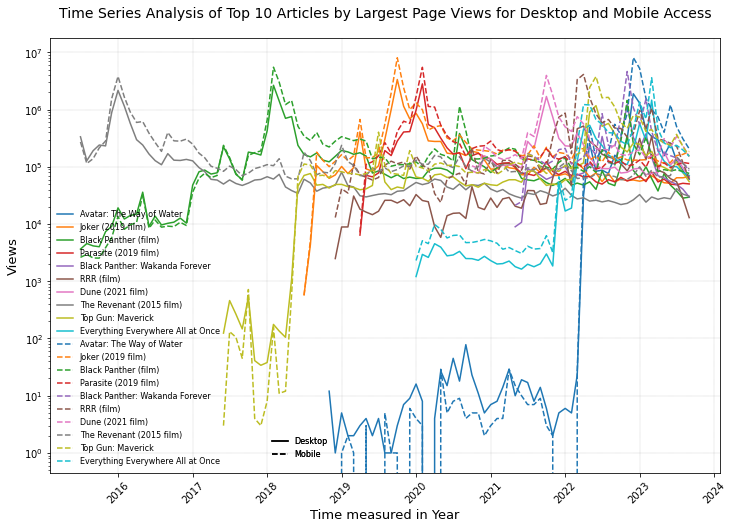

In [259]:
g1 = graph2[graph2['type'] == 'mobile']
g2 = graph2[graph2['type'] == 'desktop']


# define the size of the figure
plt.figure(figsize=(12, 8))
ax = plt.gca()

# Iterate through the top 10 articles in stored in g1 and g2 from the dataframe graph2 for mobile and desktop view
for desktop_article in peak_desktop_names:
    desktop_article_result = g2[g2['article'] == desktop_article]
    ax.plot(desktop_article_result['date'], desktop_article_result['views'], linestyle='-',
            label=desktop_article.replace('_', ' '))

for mobile_article in peak_mobile_names:
    mobile_article_result = g1[g1['article'] == mobile_article]
    ax.plot(mobile_article_result['date'], mobile_article_result['views'], linestyle='--',
            label=mobile_article.replace('_', ' '))



# Define axes labels and title 
plt.xlabel('Time measured in Year', fontsize=13)
plt.ylabel('Views', fontsize=13)
plt.yscale('log')
plt.title('Time Series Data for the Top 10 Articles with the Highest Page Views on Desktop and Mobile Platforms', pad=20,
          fontsize=14)

# This legend is encoded using colour and is used to represent the article name
legend_article_name = plt.legend(loc='lower left', prop={"size": 8}, frameon=False)
ax.add_artist(legend_article_name)

# This legend is used to differentiate between the top 10 articles viewed from the desktop or mobile using a different
# encoding
linestyles = {'Desktop': '-', 'Mobile': '--'}
legend_lines = [Line2D([0], [0], color='black', linestyle=linestyle) for linestyle in linestyles.values()]
legend_access_type = ax.legend(legend_lines, linestyles.keys(), bbox_to_anchor=(0.425, 0.1), prop={"size": 8},
                    frameon=False)
ax.add_artist(legend_access_type)


plt.setp(plt.gca().get_xticklabels(), rotation=45)
plt.grid(True, linestyle='--', color='gray', linewidth=0.2)
plt.show()

## Graph 3: Fewest Months of Data
**Description:** The third graph should show pages that have the fewest months of available data. These will all be relatively short time series and should contain a set of the most recent academy award winners. Your graph should show the 10 articles with the fewest months of data for desktop access and the 10 articles with the fewest months of data for mobile access.

**Process:** The first step is detailed in the description, which is to find the articles with the fewest months of available data. :
```
least_mobile = {
    'article_name1': months_of_data,
    'article_name2': months_of_data,
    'article_name3': months_of_data,
    ...
}
```

In [261]:
least_mobile = {}
least_desktop = {}
for item in mobile['items']:
    article_name = item['article']
    if article_name in least_mobile:
        least_mobile[article_name] += 1
    else:
        least_mobile[article_name] = 1
        
for item in desktop['items']:
    article_name = item['article']
    if article_name in least_desktop:
        least_desktop[article_name] += 1
    else:
        least_desktop[article_name] = 1

The created dictionaries in the code above can be sorted in ascending order and the first ten article names can be extracted for this use case


In [265]:
least_mobile = sorted(least_mobile.items(), key=lambda x: x[1])
least_desktop = sorted(least_desktop.items(), key=lambda x: x[1])

least_mobile = least_mobile[:10]
least_desktop = least_desktop[:10]

Extract the names of the articles with the least number of months from the above structures

In [266]:
least_mobile_names = list(dict(least_mobile).keys())
least_desktop_names = list(dict(least_desktop).keys())

### Creating a dataframe that can be used for the visualization

Using the operations and intermediary data structures above, all the information is consolidates into a dataframe with meaningful column names that can be used while creating the visualizations.

graph3 is a dataframe with 4 columns:
1. article - the name of the article 
2. views - the monthly views for that article 
3. date - the timestamp field to define the month 
4. type - defines the type of device. It can take 2 values: mobile or desktop

In [297]:
graph3 = pd.DataFrame(columns = ['article', 'views', 'date', 'type'])
for item in mobile['items']:
    if item['article'] in least_mobile_names:
        d = {'article': item['article'], 'views': item['views'], 'date': item['timestamp'], 'type': 'mobile'}
        graph3 = graph3.append(d,
        ignore_index = True)
for item in desktop_views['items']:
    if item['article'] in least_desktop_names:
        d = {'article': item['article'], 'views': item['views'], 'date': item['timestamp'], 'type': 'desktop'}
        graph3 = graph3.append(d,
        ignore_index = True)

The date value in this dataframe is taken from the original API response which is in the format %Y%m%d%H and it converted to the pandas default datetime format

In [273]:
graph3['date'] = pd.to_datetime(graph3['date'], format='%Y%m%d%H')
graph3.head()

,article,views,date,type
0,Eskimo_(1933_film),103,2022-10-01,mobile
1,Eskimo_(1933_film),502,2022-11-01,mobile
2,Eskimo_(1933_film),401,2022-12-01,mobile
3,Eskimo_(1933_film),360,2023-01-01,mobile
4,Eskimo_(1933_film),313,2023-02-01,mobile


## Plotting the graph

The code below is used to plot the graph which show pages that have the fewest months of available data. This graph has twenty lines (10 for mobile views and 10 for desktop views). 
* The legend for these lines can be found in the legend.
* The Y-axis represents the monthly pageviews for these articles. 
* The X-axis represents time measured in years.

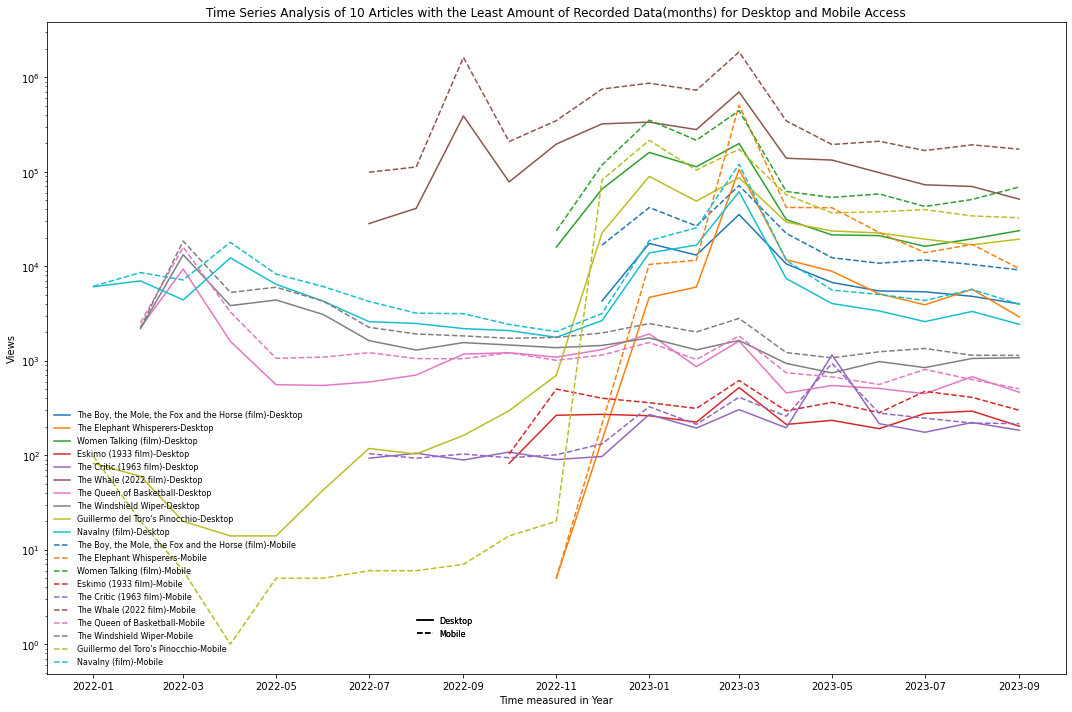

In [292]:
plt.figure(figsize = (15,10))

g1 = graph3[graph3['type'] == 'mobile']
g2 = graph3[graph3['type'] == 'desktop']
ax = plt.gca()

for article_name in least_mobile_names:
    desktop_to_plot_df = g2[g2['article'] == article_name]
    plt.semilogy(desktop_to_plot_df['date'], desktop_to_plot_df['views'], label=article_name.replace('_',' ')+'-Desktop')
for article_name in least_desktop_names:
    mobile_to_plot_df = g1[g1['article'] == article_name]
    plt.semilogy(mobile_to_plot_df['date'], mobile_to_plot_df['views'], linestyle = 'dashed', label=article_name.replace('_',' ')+'-Mobile')

plt.title('Time Series Analysis of 10 Articles with the Least Amount of Recorded Data(months) for Desktop and Mobile Access')
plt.xlabel('Time measured in Year')
plt.ylabel('Views')

# This legend is encoded using colour and is used to represent the article name
legend_article_name = plt.legend(loc='lower left', prop={"size": 8}, frameon=False)
ax.add_artist(legend_article_name)

# This legend is used to differentiate between mobile and desktop access type
linestyles = {'Desktop': '-', 'Mobile': '--'}
legend_lines = [Line2D([0], [0], color='black', linestyle=linestyle) for linestyle in linestyles.values()]
legend_access_type = ax.legend(legend_lines, linestyles.keys(), bbox_to_anchor=(0.425, 0.1), prop={"size": 8},
                    frameon=False)
ax.add_artist(legend_access_type)

plt.tight_layout()
plt.show()